2-Octave/gen 2 readout Jupyter notebook (development)  

Dec 9, 2025  
Ruixuan (Matt) Xie  
MattXie956@gmail.com  

Compatible gateware version:  
gateware_v16p0

In [ ]:
from IPython.display import HTML
HTML("""
<script>
require(['base/js/namespace'], function(Jupyter) {
    Jupyter.notebook.get_cells().forEach(function(cell) {
        if (cell.metadata.tags && cell.metadata.tags.includes('hide_input')) {
            cell.element.find('.input').hide();
        }
        if (cell.metadata.tags && cell.metadata.tags.includes('hide_output')) {
            cell.element.find('.output').hide();
        }
        if (cell.metadata.tags && cell.metadata.tags.includes('hide_cell')) {
            cell.element.hide();
        }
    });
});
</script>
""")

In [ ]:
# from IPython.display import HTML
# HTML("""
# <script>
# require(['base/js/namespace'], function(Jupyter) {
#     Jupyter.notebook.get_cells().forEach(function(cell) {
#         cell.element.show();
#         cell.element.find('.input').show();
#         cell.element.find('.output').show();
#     });
# });
# </script>
# """)

In [ ]:
# # Checking device temperature
# import os

# # Base path (adjust device number if needed based on 'ls /sys/bus/iio/devices')
# base_path = '/sys/bus/iio/devices/iio:device0'

# def read_temp(channel_prefix):
#     raw_path = os.path.join(base_path, f'{channel_prefix}_raw')
#     offset_path = os.path.join(base_path, f'{channel_prefix}_offset')
#     scale_path = os.path.join(base_path, f'{channel_prefix}_scale')
    
#     with open(raw_path, 'r') as f:
#         raw = float(f.read().strip())
#     with open(offset_path, 'r') as f:
#         offset = float(f.read().strip())
#     with open(scale_path, 'r') as f:
#         scale = float(f.read().strip())
    
#     temp_c = ((raw + offset) * scale) / 1000.0
#     return temp_c

# # PS temperature
# ps_temp = read_temp('in_temp0_ps_temp')
# print(f"PS Temperature: {ps_temp:.2f} °C")

# # PL temperature
# pl_temp = read_temp('in_temp2_pl_temp')
# print(f"PL Temperature: {pl_temp:.2f} °C")

from docs, Recommended Maximum Operating Junction Temperature (Commercial Grade): 100°C. Operation above 100°C is possible for a limited time. Operating Ambient Temperature Range (Board Level): 0°C to +45°C

# Imports

In [1]:
%matplotlib notebook

from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import numpy as np
from matplotlib import pyplot as plt
import time
import os

# Gateware upload

In [2]:
# FIRMWARE UPLOAD
gateware = Overlay("gateware/gateware_v16p0.xsa",ignore_version=True)  #

# INITIALIZING PLLs
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

# Constants

In [3]:
fs = 1.024e9
parallel_factor = 4
psb_channel_count = 2048
accum_length = 1024
snapBinLength = 256

# Gateware functions

In [4]:
# ---------------functions that involve overlay-----------------------------
def _gateware_chan(gateware, chan):
    """
    Returns the handle to the specified readout channel in the overlay gateware.

    Args:
        gateware (pynq.overlay.Overlay): 
            The uploaded overlay object.
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.

    Returns:
        pynq.overlay.DocumentHierarchy: 
            The gateware channel object corresponding to the requested channel.

    """
    return {
        1: gateware.chan1,
        2: gateware.chan2,
        3: gateware.chan3,
        4: gateware.chan4,
    }[chan]


def resetReadout(chan):
    '''
    Resets a readout chain.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        
    Notes: 
        Under-tested, do not use if run into issues with this.
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    chan_access.GPIO.axi_gpio_0.write(0x0,2)


def startReadout(chan):
    '''
    Starts a readout chain.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
            
    Notes: 
        In the 4 chain design, starting chan1 will start all chans.
        This behaviour can be modified if desired.
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    chan_access.GPIO.axi_gpio_0.write(0x0,0)
    chan_access.GPIO.axi_gpio_0.write(0x0,1)


def _setNCLO(chan, lofreq, ASU=False):

    # lofreq *= freqOffsetFixHackFactor() # Fequency offset fix
    # implemented in tones._writeComb and alcove_base._setNCLO

    # import xrfdc
    rf_data_conv = gateware.usp_rf_data_converter_0
    
    if ASU:
        tb_indices = {
            1: [1,0,1,3], 2: [1,1,1,2], 3: [0,1,1,0], 4: [0,0,1,1]}
    else:
        tb_indices = {
            1: [0,0,1,3], 2: [0,1,1,2], 3: [1,0,1,1], 4: [1,1,1,0]}

    ii = tb_indices[chan]
    adc = rf_data_conv.adc_tiles[ii[0]].blocks[ii[1]]
    dac = rf_data_conv.dac_tiles[ii[2]].blocks[ii[3]]

    adc.MixerSettings['Freq'] = -lofreq
    dac.MixerSettings['Freq'] = lofreq
    adc.UpdateEvent(xrfdc.EVENT_MIXER)
    dac.UpdateEvent(xrfdc.EVENT_MIXER)
    
    path = f"twoOctaveReadout_files/f_center_{chan}.npy"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.save(path, lofreq*10**6)


def setFFTscale(chan, scale=2016):
    '''
    Sets the internal scaling of the FFT module.
    
    Args: 
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        scale (ufix_10):
            Each HIGH bit enables shift to the right at the FFT stage.
            
    Notes: 
        FFT is on the receive side of DSP
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    gpio_4_slot_2_word = int(scale)
    chan_access.GPIO.axi_gpio_4.write(0x08,gpio_4_slot_2_word)
    
    
def setAccumLenAndSnapBinLen(chan, acc_factor, bin_len):
    '''
    Sets the accumulation factor (averaging length) in the receive DSP, which will impact output rate.
    Modifies the data structure returned by getSnapData(*, mux_sel=3).
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        acc_factor (int): 
            The accumulation length of receive outputs (the length of avg filter).
        bin_len (int): 
            Determines the number of clk cycles to be captured by getSnapData(mux_sel=3), accepts value in [5,512].
                Example: 
                    Capture all 2048 bins if set to 512,
                    1024 bins if set to 256.
                       
    Notes:
        parallel_factor=4 and psb_channel_count=2048 are specific to gateware, not arbitrary,
        these values probably should be in a config file
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    acc_length = int(psb_channel_count/parallel_factor * acc_factor - 4)
    getAccumChan = int(bin_len - 3)
    
    chan_access.GPIO.axi_gpio_3.write(0x00, getAccumChan * 2**23 + acc_length)
            
            
def setPSBscaleConst(chan, C=2**15):
    '''
    Scales the magnitude of the waveform at the output of PSB, by C/2^15.
    
    Args: 
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        C (ufix_29):
            Output magnitude = input magnitude * C / 2^15.
    Return:
        ov_flag (bin)
            
    Notes: This is intended for scaling the PSB outputs to the DAC maximum range. It can cause overflow (saturation)
          if C is too large.
    '''
    gwc = _gateware_chan(gateware, chan)
    
    gwc.GPIO.axi_gpio_5.write(0x00, int(0b111<<29 | int(C)))
    gwc.GPIO.axi_gpio_5.write(0x00, int(C))
    ov_flag = gwc.GPIO.axi_gpio_5.read(0x08)
    subsystems = ["psb-ifft", "psb-overlap-add", "psb-post-scale"]

    ov_status = {
        name: bool(ov_flag & (1 << i))
        for i, name in enumerate(subsystems)
    }
    
    return ov_status


def _writeTone(chan, mem, addr, dphi, init_re, init_im):
    '''
    Writes one tone, which is defined by its frequency (dphi) and initial vector (init_re, init_im).

    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        mem (int {0,1,2,3,4,5,6,7}): 
            An index that maps to one of the 8 BRAMs on 8 parallel paths.
        addr (uint): 
            The address of the write operation.
        dphi (float): 
            The step in phase which defines the frequency of the tone from bin center.
            Note: Units are radians [rad].
        init_re (float),
        init_im (float): 
            The real and imaginary parts of the initial vector.
            Note: The maximum magnitude of the initial vector is 1.
    
    Notes:
        Currently not possible to only change the frequency of the tone without setting its initial vector.
        To enable that, the write_enable signal needs to be separated in gateware.
    '''
    
    chan_access = _gateware_chan(gateware, chan)

    # Write initial vector
    init_re_write = _to_xbit_unsigned(int(np.round(init_re * 2**16)), 18)
    init_im_write = _to_xbit_unsigned(int(np.round(init_im * 2**16)), 18)
    chan_access.GPIO.axi_gpio_2.write(0x00, init_re_write)
    chan_access.GPIO.axi_gpio_2.write(0x08, init_im_write)

    # Only defined for mem in [0..7]
    mem_to_bit_value = {
        0: 1,
        1: 16,
        2: 2,
        3: 32,
        4: 4,
        5: 64,
        6: 8,
        7: 128,
    }
    if mem not in mem_to_bit_value:
        return

    # Determine if this mem index should be π-shifted (odd numbers)
    if mem % 2 == 1:
        dphi_eff = _wrap_angle(dphi + np.pi)
    else:
        dphi_eff = dphi

    dphi_write, _ = _rad2int(dphi_eff)

    # Compute word and select bit pattern
    gpio_1_slot_2_word = int((addr << 16) + dphi_write)
    bit_value = mem_to_bit_value[mem]

    # Perform writes (same sequence as original)
    chan_access.GPIO.axi_gpio_1.write(0x08, gpio_1_slot_2_word)
    chan_access.GPIO.axi_gpio_1.write(0x00, bit_value)
    chan_access.GPIO.axi_gpio_1.write(0x00, 0)

        
def _loadAllTones(chan, bin_num, dphi, init_re, init_im):
    '''
    Writes all tones listed in 1darrays
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        bin_num (int);
            The FFT bin number of which the tone is in.
        dphi (float): 
            The step in phase which defines the frequency of the tone from bin center.
            Note: In unit [rad]
        init_re (float),
        init_im (float): 
            The real and imarinary parts of the initial vector.
            Note: The maximum magnitude of the initial vector is 1.
    
    '''
    for i in range(bin_num.size):
        _writeTone(chan, bin_num[i]%8, bin_num[i]//8, dphi[i], init_re[i], init_im[i])

        
def clearAllTones():
    '''
    Writes zeros to all tone parameters in all 4 chans.
            
    Notes: To keep a tone going while suppressing it's power,
          simply write 0 amp to it while keeping dphi and init vector
          There's another option to suppress tones in toneSelect
    '''
    
    gateware_chans = [gateware.chan1, gateware.chan2, gateware.chan3, gateware.chan4]
    for gwc in gateware_chans:
        gwc.GPIO.axi_gpio_2.write(0x00, 0)
        gwc.GPIO.axi_gpio_2.write(0x08, 0)
        for addr in range(256):
            gwc.GPIO.axi_gpio_1.write(0x08, int(addr << 16))
            gwc.GPIO.axi_gpio_1.write(0x00, 0xff)
            gwc.GPIO.axi_gpio_1.write(0x00, 0)


def clearChanTones(chan):
    '''
    Writes zeros to all tone parameters in one of the chans.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
            
    Notes: To keep a tone going while suppressing it's power,
          simply write 0 amp to it while keeping dphi and init vector
          There's another option to suppress tones in toneSelect
    '''
    
    gwc = _gateware_chan(gateware, chan)
    gwc.GPIO.axi_gpio_2.write(0x00, 0)
    gwc.GPIO.axi_gpio_2.write(0x08, 0)
    for addr in range(256):
        gwc.GPIO.axi_gpio_1.write(0x08, int(addr << 16))
        gwc.GPIO.axi_gpio_1.write(0x00, 0xff)
        gwc.GPIO.axi_gpio_1.write(0x00, 0)


def _writeToneSelect(chan, addr, data):
    '''
    Updates toneSelect parameter memory at one address
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        addr (uint): 
            The address of the write operation.
        data (ufix_12):
            The data of the write operation.
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    gpio_6_slot_2_word = int(addr)
    chan_access.GPIO.axi_gpio_6.write(0x08,gpio_6_slot_2_word)
    
    gpio_7_slot_1_word = int((data[1] << 12) + data[0])
    chan_access.GPIO.axi_gpio_7.write(0x00,gpio_7_slot_1_word)
    gpio_7_slot_2_word = int((data[3] << 12) + data[2])
    chan_access.GPIO.axi_gpio_7.write(0x08,gpio_7_slot_2_word)
    gpio_8_slot_1_word = int((data[5] << 12) + data[4])
    chan_access.GPIO.axi_gpio_8.write(0x00,gpio_8_slot_1_word)
    gpio_8_slot_2_word = int((data[7] << 12) + data[6])
    chan_access.GPIO.axi_gpio_8.write(0x08,gpio_8_slot_2_word)
    
    chan_access.GPIO.axi_gpio_6.write(0x00,1)
    chan_access.GPIO.axi_gpio_6.write(0x00,0)
    
    
def _writeToneSelectAll(chan, ToneSelMap):
    '''
    Updates the entire toneSelect LUT from ToneSelMap
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        ToneSelMap (numpy.ndarray):
            The toneSelect LUT.
    '''
    for i in range(256):
        _writeToneSelect(chan, i, ToneSelMap[i])
        

def _updateToneSelMap(chan, toneSelectInfo, turn_off_unused_bin=True):
    '''
    It updates the init toneSelMap base on the toneSelectInfo.
    Used in case of 2 tones per bin. 
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        toneSelectInfo (numpy.ndarray):
            An array with bin reuse mapping information.
        turn_off_unused_bin (bool):
            True: remove the duplicate tone from bin reuse mechanism.
    '''
    toneSelectMap = genInitToneSelMap()
    for value in toneSelectInfo.T:
        twoTone_bin, unused_bin = value
        temp = toneSelectMap[unused_bin//8, unused_bin%8]
        toneSelectMap[twoTone_bin//8, twoTone_bin%8] = temp
        if turn_off_unused_bin:
            toneSelectMap[unused_bin//8, unused_bin%8] = 0
    _writeToneSelectAll(chan, toneSelectMap)
    
    
def _writeBinMap(chan, addr, data):
    '''
    Write to gateware registers via GPIO.
    Updates the bin select mapping (LUT) in the receive.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        addr (uint): 
            The address of the write operation.
        data (ufix_22):
            The data of the write operation.
            
    Notes:
        The bin map RAM are accecced 2 addrs at a time, 
        only the first addr need to be supplied, each addr take two values
        each 11 bits concatenated.
        For example, if addr=n, then 
        concact(data[1],data[0])LSB -> addr n
        concact(data[3],data[2])LSB -> addr n+1
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    gpio_9_slot_1_word = int((data[1]<<21) + (data[0]<<10) + addr)
    chan_access.GPIO.axi_gpio_9.write(0x00, gpio_9_slot_1_word)
    gpio_9_slot_2_word = int((data[3]<<12) + (data[2]<<1) + 0)
    chan_access.GPIO.axi_gpio_9.write(0x08, gpio_9_slot_2_word)
    
    gpio_9_slot_2_word = int((data[3]<<12) + (data[2]<<1) + 1)
    chan_access.GPIO.axi_gpio_9.write(0x08, gpio_9_slot_2_word)
    gpio_9_slot_2_word = int((data[3]<<12) + (data[2]<<1) + 0)
    chan_access.GPIO.axi_gpio_9.write(0x08, gpio_9_slot_2_word)
    
def _loadBinMap(chan, bin_map):
    '''
    Updates the bin select mapping (LUT) in the receive.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        bin_map (numpy.ndarray):
            Array of bin select mapping LUT.
    '''
    bin_map_reshape = bin_map.reshape((512, 4))
    for i in range(512):
        _writeBinMap(chan, 2*i, bin_map_reshape[i])
        

def initBinMap(chan):
    '''
    Initialize the bin select mapping (LUT) to default natural order (0,1,2,...).
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
    '''
    _loadBinMap(chan, np.arange(2048, dtype='int'))
    
    
def _writeBeatDphi(chan, mem, addr, beatDphi):
    '''
    Write to gateware registers via GPIO.
    Updates the beat frequencies corresponding to each tone, 
    for the digital down conversion (DDC) in receive.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        mem (int {0,1,2,3}):
            An index that maps to one of the 4 BRAMs on 4 parallel paths.
        addr (uint): 
            The address of the write operation.
        beatDphi (float):
            The step in phase that defines the beat frequency, in unit [rad].     
    '''
    chan_access = _gateware_chan(gateware, chan)
    
    beatDphi_write,_ = _rad2int(beatDphi)
    gpio_4_slot_1_word = int((addr << 20) + (beatDphi_write << 4))
    
    chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word)
    if mem == 0:
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word + 2**0)
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word)
    elif mem == 1:
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word + 2**1)
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word)
    elif mem == 2:
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word + 2**2)
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word)
    elif mem == 3:
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word + 2**3)
        chan_access.GPIO.axi_gpio_4.write(0x00,gpio_4_slot_1_word)
        
        
def _loadBeatDphiMap(chan, beat_dphi_map):
    '''
    Updates the beat frequencies corresponding to each tone, 
    for the digital down conversion (DDC) in receive.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        beat_dphi_map (numpy.ndarray):
            beat dphi LUT values.
    '''
    beat_dphi_map_reshape = beat_dphi_map.reshape((512, 4))
    for addr in range(512):
        for mem in range(4):
            _writeBeatDphi(chan, mem, addr, beat_dphi_map_reshape[addr, mem])


def writeComb(chan, freqs, amps, phi, save=True):
    '''
    Writes a comb of frequencies from user specified frequencies, amplitudes (magnitudes) and phases.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        freqs(numpy.1darray):
            A list of frequencies, within 1GHz bandwidth, centered at DC.
        amps (numpy.1darray):
            The normalized magnitude of each frequency, maximum = 1.0.
        phi (numpy.1darray):
            The phases of each frequency, in [rad].
    Returns:
        freqs_actual (numpy.1darray)
        bin_map (numpy.1darray)
        transmit_bin_count (int)
        secondTone_flag (bool)
        
    Notes:
        Generate optimal phases with genBestPhis() and always clearAllTones() before writing new combs.
    '''

    f_center = 1.024e9  # Hz
    init_re, init_im = _phase2vector(phi, amps)
    
    _,freqs_actual = _genWave(freqs, amps, phi)  # should make freqs_actual a stand alone function
    
    bin_num = np.round(freqs_actual/(fs/psb_channel_count)).astype(np.int64)
    
    # dphi/2pi ratio corresponds to the channel bandwidth of PSB which is 2*fs/2048
    dphi = _wrap_angle(np.pi*(freqs_actual/(fs/psb_channel_count) - bin_num))
    beat_dphi = _wrap_angle(-2*dphi)  # Careful with different sampling frequency
    
    # Represent bin numbers with all positive values
    temp = bin_num < 0
    bin_num[temp] += 2048
    
    bin_count = np.bincount(bin_num, minlength=2048)
    
    bin_map = np.zeros(2048, dtype=int)
    beat_dphi_map = np.zeros(2048, dtype=float)
    beat_dphi_2048 = np.zeros(2048, dtype=float)
    
    # For any two tones per bin instances, the second bin index will be replaced
    # with an unused bin index, and this mapping is saved in toneSelectInfo
    second_tone_index = _find_second_instance_indices(bin_num)
    if second_tone_index.size > 0:
        secondTone_flag = True
        
        all_bins = np.arange(2048)
        unused_bins = np.setdiff1d(all_bins, bin_num)
        unused_bins = unused_bins[unused_bins != 0]  # Remove 0 if present
        
        # bins to be replaced (second instances)
        orig_bins = bin_num[second_tone_index]

        # split unused bins by parity
        unused_even_bins = unused_bins[(unused_bins & 1) == 0]
        unused_odd_bins  = unused_bins[(unused_bins & 1) == 1]

        # parity requirement of replacements
        needs_even = (orig_bins & 1) == 0

        # build replacement bins aligned with second_tone_index
        replacement_bins = np.empty_like(orig_bins)
        replacement_bins[needs_even]  = unused_even_bins[:needs_even.sum()]
        replacement_bins[~needs_even] = unused_odd_bins[:(~needs_even).sum()]

        # replace ONLY the second instances
        bin_num[second_tone_index] = replacement_bins

        # record before/after mapping
        toneSelectInfo = np.vstack((orig_bins, replacement_bins))
        np.save(f"twoOctaveReadout_debug/toneSelectInfo_{chan}.npy", toneSelectInfo)  # DEBUG

        _updateToneSelMap(chan, toneSelectInfo)
        
        beat_dphi_2048[bin_num] = beat_dphi
        temp = beat_dphi_2048[toneSelectInfo[1]]
        beat_dphi_2048[toneSelectInfo[1]] = 0
        beat_dphi_2048_stack = np.vstack([beat_dphi_2048,beat_dphi_2048])
        beat_dphi_2048_stack[1, toneSelectInfo[0]] = temp
        
        np.save(f"twoOctaveReadout_debug/beat_dphi_2048_stack_{chan}.npy", beat_dphi_2048_stack)  # DEBUG

        transmit_bin_count = 0
        for i in range(2048):
            if bin_count[i] == 2:
                bin_map[transmit_bin_count] = i
                beat_dphi_map[transmit_bin_count] = beat_dphi_2048_stack[0, i]
                transmit_bin_count += 1
                bin_map[transmit_bin_count] = i
                beat_dphi_map[transmit_bin_count] = beat_dphi_2048_stack[1, i]
                transmit_bin_count += 1
            elif bin_count[i] == 1:
                bin_map[transmit_bin_count] = i
                beat_dphi_map[transmit_bin_count] = beat_dphi_2048_stack[0, i]
                transmit_bin_count += 1
    else:
        secondTone_flag = False
        _writeToneSelectAll(chan, genInitToneSelMap())
        
        beat_dphi_2048[bin_num] = beat_dphi
        transmit_bin_count = 0
        for i in range(2048):
            if bin_count[i] == 1:
                bin_map[transmit_bin_count] = i
                beat_dphi_map[transmit_bin_count] = beat_dphi_2048[i]
                transmit_bin_count += 1

    _loadBinMap(chan, bin_map)
    _loadBeatDphiMap(chan, beat_dphi_map)
    
    _loadAllTones(chan, bin_num, dphi, init_re, init_im)
    
    if save:
        f_center = np.load(f"twoOctaveReadout_files/f_center_{chan}.npy")
        freqs_rf_actual = freqs_actual + f_center
        np.save(f"twoOctaveReadout_files/f_rf_tones_comb_{chan}.npy", freqs_rf_actual)
        np.save(f"twoOctaveReadout_files/a_tones_comb_{chan}.npy", np.array([amps]))
        np.save(f"twoOctaveReadout_files/p_tones_comb_{chan}.npy", phi)
    
    return freqs_actual, bin_map, transmit_bin_count, secondTone_flag


# def writeComb_v2(chan, freqs, amps, phi, save=True):
#     """
#     Fast vectorized writeComb — keeps fixed (2048,) output arrays for hardware compatibility.
#     """
#     fs = 1.024e9
#     psb_channel_count = 2048
#     bin_size = fs / psb_channel_count
#     f_center = 1.024e9

#     init_re, init_im = _phase2vector(phi, amps)
#     _, freqs_actual = _genWave(freqs, amps, phi)

#     bin_num = np.round(freqs_actual / bin_size).astype(np.int64) % psb_channel_count
#     dphi = _wrap_angle(np.pi * (freqs_actual / bin_size - bin_num))
#     beat_dphi = _wrap_angle(-2 * dphi)

#     # Stable sort to know which tone is first in each bin
#     order = np.argsort(bin_num, kind='mergesort')
#     sorted_bins = bin_num[order]
#     sorted_beat = beat_dphi[order]

#     bin_changes = np.concatenate(([True], sorted_bins[1:] != sorted_bins[:-1]))
#     first_in_group = np.flatnonzero(bin_changes)
#     group_counts = np.diff(np.append(first_in_group, len(bin_num)))

#     has_collision = np.any(group_counts > 1)

#     # Pre-allocate fixed-size maps (exactly like original)
#     bin_map_full = np.zeros(psb_channel_count, dtype=int)
#     beat_dphi_map_full = np.zeros(psb_channel_count, dtype=float)

#     if has_collision:
#         secondTone_flag = True

#         # First tone of each bin stays → use original bin and its beat_dphi
#         first_positions = order[first_in_group]
#         bin_map_full[:len(first_positions)] = bin_num[first_positions]
#         beat_dphi_map_full[:len(first_positions)] = beat_dphi[first_positions]

#         # All later tones → redirect + reuse first tone's beat_dphi
#         later_mask = np.ones(len(bin_num), bool)
#         later_mask[first_positions] = False
#         n_redirect = later_mask.sum()

#         # Unused bins
#         used = np.bincount(sorted_bins, minlength=psb_channel_count) > 0
#         unused_bins = np.flatnonzero(~used)
#         redirected_bins = unused_bins[:n_redirect]

#         # Update redirected bin numbers (for _loadAllTones)
#         bin_num_redirected = bin_num.copy()
#         bin_num_redirected[later_mask] = redirected_bins

#         # toneSelectInfo: one entry per redirected tone
#         original_collided = np.repeat(sorted_bins[first_in_group[group_counts > 1]],
#                                       group_counts[group_counts > 1] - 1)
#         toneSelectInfo = np.vstack((original_collided, redirected_bins))

#         _updateToneSelMap(chan, toneSelectInfo, True)

#         # Fill the rest of the fixed arrays with redirected tones
#         transmit_pos = len(first_positions)
#         bin_map_full[transmit_pos:transmit_pos + n_redirect] = redirected_bins
#         # Reuse first tone's beat_dphi for the whole group
#         beat_for_group = np.repeat(beat_dphi[first_positions], group_counts)
#         beat_dphi_map_full[transmit_pos:transmit_pos + n_redirect] = beat_for_group[later_mask[order]]

#         transmit_bin_count = transmit_pos + n_redirect

#     else:
#         secondTone_flag = False
#         _writeToneSelectAll(chan, genInitToneSelMap())
#         bin_num_redirected = bin_num

#         bin_map_full[:len(bin_num)] = bin_num
#         beat_dphi_map_full[:len(bin_num)] = beat_dphi
#         transmit_bin_count = len(bin_num)

#     # ←←← Critical: pass fixed-size arrays to hardware functions
#     _loadBinMap(chan, bin_map_full)
#     _loadBeatDphiMap(chan, beat_dphi_map_full)
#     _loadAllTones(chan, bin_num_redirected, dphi, init_re, init_im)

#     if save:
#         np.save(f"twoOctaveReadout_files/f_rf_tones_comb_{chan}.npy", freqs_actual + f_center)
#         np.save(f"twoOctaveReadout_files/a_tones_comb_{chan}.npy", np.array([amps]))
#         np.save(f"twoOctaveReadout_files/p_tones_comb_{chan}.npy", phi)

#     # Return trimmed versions + count for backward compatibility
#     return (freqs_actual,
#             bin_map_full[:transmit_bin_count],      # trimmed, like original
#             transmit_bin_count,
#             secondTone_flag)
    
    
def getSnapData(chan, mux_sel, wait=0.02):
    '''
    Fetch data from gateware DSP.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        mux_sel:
            0: ADC outputs
            1: PSB outputs (DAC inputs)
            3: Receive outputs (time stream data)
    Returns:
        I, Q (numpy.ndarray):
            for data converter data, I and q are flat,
            for time stream data, I and Q have shape (n, bin)
    '''
    import numpy as np
    from pynq import MMIO
    
    # reset snap
    access = _gateware_chan(gateware, chan).GPIO.axi_gpio_3
    access.write(0x08, 3)
    access.write(0x08, 0)
    time.sleep(wait)
    
    match chan:
        case 1:
            match mux_sel:
                case 0 | 1:
                    base_addr_wide  = 0x00_A001_0000
                case 3:
                    base_addr_wide  = 0x00_A002_0000
        case 2:
            match mux_sel:
                case 0 | 1:
                    base_addr_wide  = 0x00_A003_0000
                case 3:
                    base_addr_wide  = 0x00_A004_0000
        case 3:
            match mux_sel:
                case 0 | 1:
                    base_addr_wide  = 0x00_A005_0000
                case 3:
                    base_addr_wide  = 0x00_A006_0000
        case 4:
            match mux_sel:
                case 0 | 1:
                    base_addr_wide  = 0x00_A007_0000
                case 3:
                    base_addr_wide  = 0x00_A008_0000
                    
    max_count = 65536  # 32x2048 = 65536
    mmio_wide_bram = MMIO(base_addr_wide , max_count)
    wide_data = mmio_wide_bram.array[0:16384]  # max/4, bram depth*word_bits/32bits
    
    I = np.zeros(8192)
    Q = np.zeros(8192)
    
    match mux_sel:
        case 0 | 1:
            up_PSB_q0, lw_PSB_i0 = np.int16(wide_data[0::8] >> 16), np.int16(wide_data[0::8] & 0x0000ffff)
            up_PSB_q1, lw_PSB_i1 = np.int16(wide_data[1::8] >> 16), np.int16(wide_data[1::8] & 0x0000ffff)
            up_PSB_q2, lw_PSB_i2 = np.int16(wide_data[2::8] >> 16), np.int16(wide_data[2::8] & 0x0000ffff)
            up_PSB_q3, lw_PSB_i3 = np.int16(wide_data[3::8] >> 16), np.int16(wide_data[3::8] & 0x0000ffff)
            up_ADC_i1, lw_ADC_i0 = np.int16(wide_data[4::8] >> 16), np.int16(wide_data[4::8] & 0x0000ffff)
            up_ADC_i3, lw_ADC_i2 = np.int16(wide_data[5::8] >> 16), np.int16(wide_data[5::8] & 0x0000ffff)
            up_ADC_q1, lw_ADC_q0 = np.int16(wide_data[6::8] >> 16), np.int16(wide_data[6::8] & 0x0000ffff)
            up_ADC_q3, lw_ADC_q2 = np.int16(wide_data[7::8] >> 16), np.int16(wide_data[7::8] & 0x0000ffff)
            
            if mux_sel == 0:
                I[0::4] = lw_ADC_i0
                I[1::4] = up_ADC_i1
                I[2::4] = lw_ADC_i2
                I[3::4] = up_ADC_i3
                Q[0::4] = lw_ADC_q0
                Q[1::4] = up_ADC_q1
                Q[2::4] = lw_ADC_q2
                Q[3::4] = up_ADC_q3
            elif mux_sel == 1:
                I[0::4] = lw_PSB_i0
                I[1::4] = lw_PSB_i1
                I[2::4] = lw_PSB_i2
                I[3::4] = lw_PSB_i3
                Q[0::4] = up_PSB_q0
                Q[1::4] = up_PSB_q1
                Q[2::4] = up_PSB_q2
                Q[3::4] = up_PSB_q3
        case 3:
            i0 = (np.int32(wide_data[0::8])).astype("float")
            q0 = (np.int32(wide_data[1::8])).astype("float")
            i1 = (np.int32(wide_data[2::8])).astype("float")
            q1 = (np.int32(wide_data[3::8])).astype("float")
            i2 = (np.int32(wide_data[4::8])).astype("float")
            q2 = (np.int32(wide_data[5::8])).astype("float")
            i3 = (np.int32(wide_data[6::8])).astype("float")
            q3 = (np.int32(wide_data[7::8])).astype("float")
            
            I[0::4] = i0
            I[1::4] = i1
            I[2::4] = i2
            I[3::4] = i3
            Q[0::4] = q0
            Q[1::4] = q1
            Q[2::4] = q2
            Q[3::4] = q3
            
#             I /= 2**14
#             Q /= 2**14
    return I, Q


def set_fine_nco_frequency(chan, freq_mhz):
    """
    Set the fine NCO (Numerically Controlled Oscillator) frequency.
    
    Args:
        chan (int): 
            Channel index (1–4) specifying which readout chain to access.
        freq_mhz (float);
            Frequency in MHz.
    """

    import numpy as np

    try:
        # Constants
        fs_hz = 1.024e9                    # System sample rate (Hz); 512e6 Hz
        nco_bits = 22                      # Width of NCO phase accumulator
        freq_resolution_hz = fs_hz / 2**nco_bits  # Frequency step per integer DTW

        # Convert desired frequency (MHz) to Hz
        freq_hz = freq_mhz * 1e6

        # Compute digital tuning word (DTW)
        dtw = int(np.round(freq_hz / freq_resolution_hz))

        # Actual frequency that will be set
        actual_freq_hz = dtw * freq_resolution_hz

        # Write DTW to gateware register for the given channel
        chan_access = _gateware_chan(gateware, chan)
        chan_access.GPIO.axi_gpio_10.write(0x00,dtw)
        
        return dtw

    except Exception as e:
        print(f"set_fine_nco_frequency Error: {e}")


def _sweep(chan, f_center, freqs, N_steps, chan_bandwidth=None, N_accums=8, wait1=0.1, wait2=0.1):
    """
    Perform a stepped LO frequency sweep with existing comb centered at f_center.
    
    INPUTS
    f_center:        (float) Center LO frequency for sweep [MHz].
    freqs:           (1D array of floats) Comb frequencies [Hz].
    N_steps:         (int) Number of LO frequencies to divide each channel into.
    chan_bandwidth:  (float) Bandwidth of each channel [MHz].
    
    RETURN: tuple(f, S21)
    f:               (1D array of floats) Central frequency for each bin.
    Z:               (1D array of complex) S_21 complex I+jQ for each bin.
    """

    import numpy as np
    from time import sleep
    import time

    N_steps  = max(1, int(N_steps)) # minimum 1 step
    f_center = float(f_center)
    N_accums = int(N_accums)

    # sort ascending and remove exact duplicates
    # for example:
        # target find resonators uses min in tone channel
        # so two resonators in same tone channel will lead to duplicates
    freqs = np.unique(freqs)

    # build LO steps
    if chan_bandwidth: # LO bandwidth given
        bw = float(chan_bandwidth) # MHz
    else:              # use tone difference
        bw = np.diff(freqs)[0]/1e6 # MHz
    flos = np.linspace(f_center-bw/2., f_center+bw/2., N_steps, endpoint=False)

    def _Z(lofreq, Naccums=N_accums):
        set_fine_nco_frequency(chan, lofreq)
        time.sleep(wait1) # 0.003 s optimum to settle freq from testing
        Is, Qs = getSnapData(chan, 3, wait2)
        data = (Is + 1.j * Qs)  # convert I and Q to complex
        data = data.reshape((-1, 1024))
        Z = np.mean(data, axis=0)

        return Z[0:len(freqs)] # only return relevant slice
    
    start_time = time.time()

    # loop over each LO freq and flatten Z and f
    Z = (np.array([_Z(lofreq-f_center) for lofreq in flos]).T).flatten()
    f = np.array([flos*1e6 + ftone for ftone in freqs]).flatten()

    print(f"_sweep time: {time.time() - start_time}")
        
    set_fine_nco_frequency(chan, 0) # reset LO

    return (f, Z)


def _sweep2(chan, f_center, freqs, N_steps, chan_bandwidth=None, N_accums=8, wait1=0.1, wait2=0.1):
    """
    Perform a stepped LO frequency sweep with existing comb centered at f_center.
    With phase correction.
    
    INPUTS
    f_center:        (float) Center LO frequency for sweep [MHz].
    freqs:           (1D array of floats) Comb frequencies [Hz].
    N_steps:         (int) Number of LO frequencies to divide each channel into.
    chan_bandwidth:  (float) Bandwidth of each channel [MHz].
    
    RETURN: tuple(f, S21)
    f:               (1D array of floats) Central frequency for each bin.
    Z:               (1D array of complex) S_21 complex I+jQ for each bin.
    """

    import numpy as np
    from time import sleep
    import time

    f_tones = np.load(f"twoOctaveReadout_files/f_rf_tones_comb_{chan}.npy") - 1.024e9
    a_tones = np.load(f"twoOctaveReadout_files/a_tones_comb_{chan}.npy")
    p_tones = np.load(f"twoOctaveReadout_files/p_tones_comb_{chan}.npy")
    
    N_steps  = max(1, int(N_steps)) # minimum 1 step
    f_center = float(f_center)
    N_accums = int(N_accums)

    # sort ascending and remove exact duplicates
    # for example:
        # target find resonators uses min in tone channel
        # so two resonators in same tone channel will lead to duplicates
    freqs = np.unique(freqs)

    # build LO steps
    if chan_bandwidth: # LO bandwidth given
        bw = float(chan_bandwidth) # MHz
    else:              # use tone difference
        bw = np.diff(freqs)[0]/1e6 # MHz
    flos = np.linspace(f_center-bw/2., f_center+bw/2., N_steps, endpoint=False)

    def _Z(lofreq, Naccums=N_accums):
        dtw = set_fine_nco_frequency(chan, lofreq)
        correction = 2*np.pi*(dtw/2**22)*372.823443759
        phis_corrected = p_tones + correction
        writeComb(chan, f_tones, a_tones, phis_corrected, save=False)
        time.sleep(wait1)
        Is, Qs = getSnapData(chan, 3, wait2)
        data = (Is + 1.j * Qs)  # convert I and Q to complex
        data = data.reshape((-1, 1024))
        Z = np.mean(data, axis=0)

        return Z[0:len(freqs)] # only return relevant slice
    
    start_time = time.time()

    # loop over each LO freq and flatten Z and f
    Z = (np.array([_Z(lofreq-f_center) for lofreq in flos]).T).flatten()
    f = np.array([flos*1e6 + ftone for ftone in freqs]).flatten()

    print(f"_sweep time: {time.time() - start_time}")
        
    set_fine_nco_frequency(chan, 0) # reset LO
    writeComb(chan, f_tones, a_tones, p_tones, save=False)

    return (f, Z)


def timestreamOn(chan, on=True):
    '''Turn the UDP timestream on (or off) for the current drone.'''

    # input parameter casting
    on = str(on) in {True, 1, '1', 'True', 'true'}

#     udp_control = cfg_b.gateware.gpio_udp_info_control
    udp_control = gateware.udp_control.gpio_udp_info_control
    
#     # current drone channel
#     chan = cfg_b.drid

    # bit values for this drone (01 for on, 10 for off)
    val = 0b01 if on else 0b10

    # construct the 8-bit register value with all zeros except for this drone
    reg_value = val << ((chan - 1) * 2)

    # Write the new register value
    udp_control.write(0x00, reg_value)


def userPacketInfo(chan, data):
    '''Write 16 bits of data to include in the UDP timestream packet.
    Data is drone specific.

    data: 16 bit int to write.8212+42
        Note that Redis will convert user input to string.
        e.g. 255 can be sent as:
            '255', '255.0', '0xFF', '0b11111111', '0o377'
        If conversion fails, then will write 0 instead.
    '''

    # input parameter casting
    data = safe_cast_to_int(data) # returns None if fails
    data = 0 if data is None else data # fails to 0
    data = data & 0xFFFF # ensure data is 16 bits

#     udp_control = cfg_b.gateware.gpio_udp_info_control
    udp_control = gateware.udp_control.gpio_udp_info_control

#     # current drone channel
#     chan = cfg_b.drid

    drone_shift = 16 # Shift for drone ID
    edge_trigger = 19 # Shift for edge-triggered write

    val = ((chan-1)<<drone_shift) | data

    # Write to tmp reg then trigger write to final reg
    udp_control.write(0x08, val)
    udp_control.write(0x08, (1<<edge_trigger) | val)  # edge trigger
    udp_control.write(0x08, val)


def writeChannelCount(chan, num_chans):
    '''Write the number of channels to include in the UDP timestream packet.
    Drone specific.

    num_chans: (int) 16 bits, number of channels.
    '''

    # input parameter casting
    num_chans = safe_cast_to_int(num_chans) # returns None if fails
    num_chans = 0 if num_chans is None else num_chans # fails to 0
    num_chans = num_chans & 0xFFFF # ensure data is 16 bits

#     udp_control = cfg_b.gateware.gpio_udp_info_control
    udp_control = gateware.udp_control.gpio_udp_info_control

#     # current drone channel
#     chan = cfg_b.drid

    count_shift = 18 # Shift for count enable (as opposed to data)
    drone_shift = 16 # Shift for drone ID
    edge_trigger = 19 # Shift for edge-triggered write

    val = (1<<count_shift) | ((chan-1)<<drone_shift) | num_chans

    # Write to tmp reg then trigger write to final reg
    udp_control.write(0x08, val)
    udp_control.write(0x08, (1<<edge_trigger) | val)  # edge trigger
    udp_control.write(0x08, val)


# ===================================functions that don't involve overlay====================================================
def safe_cast_to_int(data_str):
    try:
        if isinstance(data_str, str):
            if data_str.lower().startswith('0x'):   # hex
                return int(data_str, 16)
            elif data_str.lower().startswith('0b'): # bin
                return int(data_str, 2)
            elif data_str.lower().startswith('0o'): # oct
                return int(data_str, 8)
        else:                                   # everything else
            return int(float(data_str)) # catches sci, underscores, etc.
    except (ValueError, SyntaxError) as e:
        # raise ValueError(f"Invalid integer string format: {data_str}") from e
        return None


def get_safe_frequencies(freqs):
    """
    Filters the input frequencies based on system limitations.
    
    Args:
        freqs (array-like): Input frequencies in Hz.
    
    Returns:
        np.ndarray: Safe frequencies satisfying the limitations.
    """
    freqs = np.asarray(freqs)
    
    # Limitation 1: Filter frequencies within [-500e6, 500e6] Hz
    mask = (freqs >= -500e6) & (freqs <= 500e6)
    freqs = freqs[mask]
    
    if len(freqs) == 0:
        return np.array([])
    
    # Define bin parameters
    bin_size = 5e5  # 500 kHz
    offset = 2.5e5  # 250 kHz
    
    # Compute bin indices
    bins = np.floor((freqs + offset) / bin_size)
    
    # Get unique bin indices
    unique_bins = np.unique(bins)
    
    # Collect kept frequencies
    kept = []
    
    for b in unique_bins:
        # Get frequencies in this bin
        in_bin_mask = (bins == b)
        in_bin_freqs = freqs[in_bin_mask]
        
        if len(in_bin_freqs) <= 2:
            kept.append(in_bin_freqs)
        else:
            # Randomly select 2 frequencies
            selected = np.random.choice(in_bin_freqs, size=2, replace=False)
            kept.append(selected)
    
    # Concatenate and return
    safe_freqs = np.concatenate(kept)
    return safe_freqs


def genInitToneSelMap():
    '''
    Generate a default tone select mapping LUT for initialization/reset.
    
    Returns:
        toneSelectMap (numpy.ndarray)
    '''
    toneSelectMap = np.arange(2048, dtype=np.uint16).reshape((256,8))
    for i in range(8):
        addr = np.arange(256, dtype=np.uint16)
        para = np.ones(256, dtype=np.uint16) * i
        onoff = np.ones(256, dtype=np.uint16)
        toneSelectMap[:, i] = addr << 4 | para << 1 | onoff
    return toneSelectMap


def decodeToneSelMap(concatenated):
    '''
    This function decodes the tone select mapping values to human readable parameters.
    The tone select mapping values are three-value concatenated big integer.
    
    Returns:
        addr: address of the bin
        para: parallel path index
        onoff: turn on or off the bin
    '''
    onoff = concatenated & 0b1
    para = (concatenated & 0b1110) >> 1
    addr = concatenated >> 4
    return addr, para, onoff


def _find_second_instance_indices(freqs):
    '''
    This function is for finding the index of two tones per bin, for the bin re-assign of the second tones.
    
    Args:
        freqs (numpy.1darray): 
            assume to be in assending order
    Returns:
        second_indices (numpy.1darray):
            the indices of the second tones.
    '''
    # Find where consecutive elements are equal
    is_repeat = np.diff(freqs) == 0
    # Get indices of second instances (where is_repeat is True, take the next index)
    second_indices = np.where(is_repeat)[0] + 1
    return second_indices


def findMaxMagnitude(x):
    '''
    Args:
        x (numpy.ndarray): an array of complex values
    Returns:
        max (float): the maximum magnitude among the complex values
    '''
    return np.max(np.abs(x))
    
    
def _genWave(freqs, amps, phis, fs=1.024e9, lut_len=2**21):
    '''
    Generates a waveform based on requested frequencies, magnitudes, and phases, using np.fft.ifft
    
    Notes:
        Since 2-octave gateware use PSB to synthesize wave, this is only used for genAmpsAndPhis.
    '''
    freqs = np.real(freqs)
    amps  = np.real(amps)
    phis  = np.real(phis)
    
    # Compute frequency bins
    bin_num      = np.round(freqs/(fs/lut_len)).astype(np.int64)
    freqs_actual = bin_num*(fs/lut_len)
    
    # Vectorized X assignment (frequency space)
    X    = np.zeros(lut_len, dtype=np.complex128)
    X[bin_num] = np.exp(-1j*phis)*amps
    
    # Compute IFFT
    x = np.fft.ifft(X, norm='backward')*lut_len
    
    return x, freqs_actual

def genBestPhis(freqs, magnitude=1.0, phase_trials=5):  
    '''
    Generates optimized phases for a set of frequencies to minimize waveform peak (crest factor).

    This function finds optimal phases for a set of sinusoidal components with given frequencies and magnitude, aiming to reduce the peak amplitude of the resulting composite waveform. It initializes amplitudes with equal values and then iteratively searches for optimal phases by randomly sampling and evaluating
    the waveform's peak. This is intended for tones to make best use of DAC's dynamic range.

    Args:
        freqs (numpy.ndarray): An array of frequencies (Hz) for the sinusoidal components.
        magnitude (float, optional): The magnitude of tones. Defaults to 1.0, which is the maximum.
        phase_trials (int, optional): The number of random phase sets to try. Defaults to 5.

    Returns:
        - best_phis (numpy.ndarray): An array of optimized phases (radians).
        - best_peak (float): The waveform peak given by the best phases

    Notes:
        - Phases are randomly sampled within the range [-pi, pi].
        To do: remove magnitude
    '''
    # number of tones
    N = len(freqs) 

    # assuming equal amplitudes
    mag = np.ones(N) * magnitude
    
    # sample random phases, choose best
    best_peak = float('inf')
    best_phis = None
    for _ in range(phase_trials):
        phis = np.random.uniform(-np.pi, np.pi, N)
        x,freqs_actual = _genWave(freqs, mag, phis)
        peak = findMaxMagnitude(x)
        if peak < best_peak:
            best_peak = peak
            best_phis = phis
            best_crest_factor = compute_crest_factor(x)
    
    return best_phis, freqs_actual, best_peak, best_crest_factor


def _phase2vector(phi, magnitude):
    '''
    Converts complex number from polar form to Cartesian form.
    '''
    Z = magnitude * np.exp(1.j*phi)
    return Z.real, Z.imag


def _to_xbit_unsigned(value, bit_width):
    '''
    Convert negative integer to an x-bit two's complement.
    
    Args:
        value (int)
        bit_width: total number of bits of the fix-point representation
        
    Notes:
        Calculate two's complement as 2^bit_width - abs(value)
    '''

    if value < 0:
        unsigned_value = (1 << bit_width) + value
    else:
        unsigned_value = value
    
    # Mask to ensure the value is within x bits
    return unsigned_value & ((1 << bit_width) - 1)


def _wrap_angle(angle):
    '''
    Args:
        angle (float):
            An angle in [rad].
    Returns:
        (float):
            An equavalent angle within the range [-pi,pi].
    '''
    return np.arctan2(np.sin(angle), np.cos(angle))


def _wrap_norm_angle(angle_pi_rad):
    '''
    Wrap the angle to the range [-pi, pi), with unit [pi rad].
    '''
    wrapped_angle = (angle_pi_rad + 1) % 2 - 1
    if wrapped_angle >= 1:
        wrapped_angle -= 2
    return wrapped_angle


def _rad2int(angle_rad):
    '''
    Convert any angle in rad to the uint16 representation in unit [pi rad]
    '''
    wrap = _wrap_angle(angle_rad)
    angle_pi_rad = wrap / np.pi
    scaled_angle_pi_rad = int(np.round(angle_pi_rad * 2**15))
#     if scaled_angle_pi_rad >= 32768:
#         scaled_angle_pi_rad = int(32767)
    angle_actual = np.int16(scaled_angle_pi_rad) * np.pi / 2**15
    return np.uint16(scaled_angle_pi_rad), angle_actual

# ------------------for data analysis and plotting---------------------------
def db(value):
    """ Convert linear value to dB value """
    return 20. * np.log10(np.abs(value) + 1e-12)


def db_relative(value):
    """ Convert linear value to dB value, normalize max to 0dB """
    magnitude = np.abs(value)
    return 20. * np.log10(magnitude / np.max(magnitude) + 1e-12)


def print_min_max(array):
    """
    reutrns the maximum and minimum absulute value in the array
    """
    print(f"{np.min(np.abs(array))} <-> {np.max(np.abs(array))}")


def compute_crest_factor(signal):
    peak_value = np.max(np.abs(signal))
    rms_value = np.sqrt(np.mean(np.abs(signal) ** 2))
    crest_factor = 20 * np.log10(peak_value / rms_value)
    return crest_factor

In [ ]:
# gateware access notes
# -------------------------PSB---------------------------------------
# chan*.GPIO.axi_gpio_0 - reset and enable
# - slot 1
# -- rst [1:1] - bool
# -- start [0:0] - bool

# chan*.GPIO.axi_gpio_1 
# - slot 1 
# -- we_even_1 [0:0] - bool
# -- we_even_2 [1:1] - bool
# -- we_even_3 [2:2] - bool
# -- we_even_4 [3:3] - bool
# -- we_odd_1 [4:4] - bool
# -- we_odd_2 [5:5] - bool
# -- we_odd_3 [6:6] - bool
# -- we_odd_4 [7:7] - bool
# - slot 2 
# -- addr [23:16] - (fix_8_0) - 256 possible addresses
# -- dphi [15:0] - (fix_16_15)

# chan*.GPIO.axi_gpio_2
# - slot 1 
# -- gin_init_re [17:0] - (fix_18_16)
# - slot 2 
# -- gin_init_im [17:0] - (fix_18_16)

# Tone Select
# chan*.GPIO.axi_gpio_6
# - slot 1
# -- ts_w [0:0] - bool
# - slot 2
# --ts_a [7:0] - ufix_8

# chan*.GPIO.axi_gpio_7
# 12'b xxxxxxxx,xxx,x
# LSB for chosing 0 or bypass
# 3 bits in the middle for selecting parallel
# 8 bits from MSB for selecting addr
# - slot 1
# -- ts_0 [11:0] - ufix_12
# -- ts_1 [23:12] - ufix_12
# - slot 2
# -- ts_2 [11:0] - ufix_12
# -- ts_3 [23:12] - ufix_12

# chan*.GPIO.axi_gpio_8
# - slot 1
# -- ts_4 [11:0] - ufix_12
# -- ts_5 [23:12] - ufix_12
# - slot 2
# -- ts_6 [11:0] - ufix_12
# -- ts_7 [23:12] - ufix_12

# ----------------------Receive-----------------------------------
# chan*.GPIO.axi_gpio_4
# - slot 1 
# -- beat_addr [28:20] - (ufix_9) # check the data type in simulink
# -- beat_dphi [19:4] - (ufix_16)
# -- beat_we3  [3:3] - (bool)
# -- beat_we2  [2:2] - (bool)
# -- beat_we1  [1:1] - (bool)
# -- beat_we0  [0:0] - (bool)
# - slot 2
# -- FFT_scale [10:0] - (ufix_11) # default value = 2016

# chan*.GPIO.axi_gpio_5
# - slot 1 (output)
# -- ov_rst    [31:29]- (bool)
# -- PSB_postScale [28:0] - (ufix_29)
# - slot 2 (input)
# -- ov_postScale [2:2] - (bool)
# -- ov_add [1:1] - (bool)
# -- ov_ifft [0:0] - (bool)

# chan*.GPIO.axi_gpio_9: binSel
# - slot 1 (output)
# -- binSel_addr [9:0] - (ufix_10)
# -- binSel_data0 [31:10] - (ufix_22)
# - slot 2 (output)
# -- binSel_we [0:0] - (bool)
# -- binSel_data1 [22:1] - (ufix_22)

#---------------------Global--------------------------------------
# chan*.GPIO.axi_gpio_3
# - slot 1 (output)
# -- accum_length [22:0] - (ufix_23) 
# -- getAccumChan [31:23] - (ufix_9)  
#      integer values in [0:511] to specify how many cycles to capture 
#      after each rising edge of the receive output tvalid, input = n_cycles - 3
#      for example, if set to (256-3=253), then 256 cycles will be captured,
#      which is half the channels (1024 channels) due to parallel by 4
# - slot 2 (output)
# -- bramx32v2_start [0:0] - (bool)  give rising edge to recapture data converter data
# -- getAccum_rst [1:1] - (bool) give rising edge to recapture receive outputs

# chan*.GPIO.axi_gpio_10: cordic mixer (fine_nco)
# - slot 1 (output)
# -- dphi [21:0] - (ufix_21)

# Readout example: getting arbitrary 1024 tones

In [5]:
path = f"twoOctaveReadout_files/"
os.makedirs(os.path.dirname(path), exist_ok=True)
path = f"twoOctaveReadout_debug/"
os.makedirs(os.path.dirname(path), exist_ok=True)

# SET ETHERNET IPS and MACS
def ethRegsPortWrite(eth_regs,
                     src_ip_int32   = int("c0a80335",16), # 192.168.3.53
                     dst_ip_int32   = int("c0a80328",16), # 192.168.3.40
                     src_mac0_int32 = int("eec0ffee",16), # 238.192.255.238
                     src_mac1_int16 = int("c0ff",16),     # 192.255
                     dst_mac0_int16 = int("ec18",16),  # last four hex of mac   # 14:eb:b6:52:ec:18(TP-Link_52:ec:18)
                     dst_mac1_int32 = int("14ebb652",16)): # first eight hex of mac
    eth_regs.write( 0x00, src_mac0_int32) 
    eth_regs.write( 0x04, (dst_mac0_int16<<16) + src_mac1_int16)
    eth_regs.write( 0x08, dst_mac1_int32)
    eth_regs.write( 0x0c, src_ip_int32)
    eth_regs.write( 0x10, dst_ip_int32)
# 00:1b:21:ed:5c:f6    
ethRegsPortWrite(gateware.ethWrapPort0.eth_regs_0, src_ip_int32=int("c0a80332",16)) # 192.168.3.50
ethRegsPortWrite(gateware.ethWrapPort1.eth_regs_0, src_ip_int32=int("c0a80333",16)) # 192.168.3.51
ethRegsPortWrite(gateware.ethWrapPort2.eth_regs_0, src_ip_int32=int("c0a80334",16)) # 192.168.3.52
ethRegsPortWrite(gateware.ethWrapPort3.eth_regs_0, src_ip_int32=int("c0a80335",16)) # 192.168.3.53

# Initialization
accum_start_gap = (psb_channel_count/parallel_factor*accum_length)//4
gateware.eth_timing_ctrl.write(0x00, int(accum_start_gap - 4))  # the gap in clk cycles in between chan start signal

for chan in range(1,5):
    setFFTscale(chan, scale=2016)
    setAccumLenAndSnapBinLen(chan, accum_length, snapBinLength)
    setPSBscaleConst(chan, C=37170*2)  # 37170
    set_fine_nco_frequency(chan, 0)  # MHz

ASU_flag = False
_setNCLO(1, 1024, ASU=ASU_flag)
_setNCLO(2, 1024, ASU=ASU_flag)
_setNCLO(3, 1024, ASU=ASU_flag)
_setNCLO(4, 1024, ASU=ASU_flag)

if ASU_flag:
    gateware.eth_timing_ctrl.write(0x08, int(0<<14 | 1<<12 | 3<<10 | 2<<8 | 2<<6 | 3<<4 | 1<<2 | 0))
else:
    gateware.eth_timing_ctrl.write(0x08, int(3<<14 | 2<<12 | 1<<10 | 0<<8 | 0<<6 | 1<<4 | 2<<2 | 3))


In [6]:
clearAllTones()  # Gateware design comes with preloaded parameters, can discuss perfered preload

In [7]:
startReadout(1)  # always start with chan1, other chans follow the start of chan1

In [ ]:
# testing chan count and info
writeChannelCount(1, 20)
writeChannelCount(2, 30)
writeChannelCount(3, 40)
writeChannelCount(4, 50)

userPacketInfo(1, 22)
userPacketInfo(2, 33)
userPacketInfo(3, 44)
userPacketInfo(4, 55)

In [ ]:
# Create an frequency list
num_tones = 1024

# ASSUMPTION: The frequency list at most have 2 tones per bin
# freqs = np.array(np.linspace(-400.00e6, 400.00e6, num_tones))
# freqs = np.array(np.linspace(-250.00e6, 250.00e6, num_tones))
# freqs = np.array(np.linspace(-128e6+125e3, 128e6-250e3+125e3, num_tones))
# for i in range(1024):
#     if i % 2 != 0:
#         freqs[i] += 187.5e3
# freqs = np.loadtxt("scheduled_850_tones.csv", delimiter=',')
freqs = np.arange(-256e6, 256e6, 500e3)  # 1024 tones
# freqs = np.arange(-250e6, 250e6, 500e3)  # 1000 tones
# freqs = np.arange(0, 500e6, 500e3)
# freqs = np.array([0.5e6, 1e6, 1.1e6, 1.5e6]) + 2e6
# freqs = np.array([0.5e6, 1e6, 1.5e6]) + 2e6
# freqs = np.array([5e6])

print(freqs[0:4])
safe_freqs = get_safe_frequencies(freqs)

In [26]:
import numpy as np

# -----------------------------
# User-controlled parameter
# -----------------------------
n = 1  # number of empty sub-bands between active ones (0, 1, 2, or 3)

# -----------------------------
# System constants
# -----------------------------
subband_bw = 500e3          # Hz
tone_off   = 31.25e3 * 2    # 125e3 Hz (even split)

# -----------------------------
# Derived quantities
# -----------------------------
n_tones        = 1024
tones_per_sb   = 2
n_active_sb    = n_tones // tones_per_sb          # 512
step           = n + 1                            # sub-band index increment

# Center active sub-bands around DC
idx_span  = step * (n_active_sb - 1)
start_idx = -idx_span // 2

active_sb = start_idx + step * np.arange(n_active_sb, dtype=np.int64)

# -----------------------------
# Generate frequencies
# -----------------------------
centers = active_sb.astype(np.float64) * subband_bw
freqs = np.sort(np.r_[centers - tone_off, centers + tone_off])

# freqs is a (1024,) NumPy array of unique frequencies in Hz
safe_freqs = get_safe_frequencies(freqs)
print(safe_freqs.shape)

(1024,)


<IPython.core.display.Javascript object>


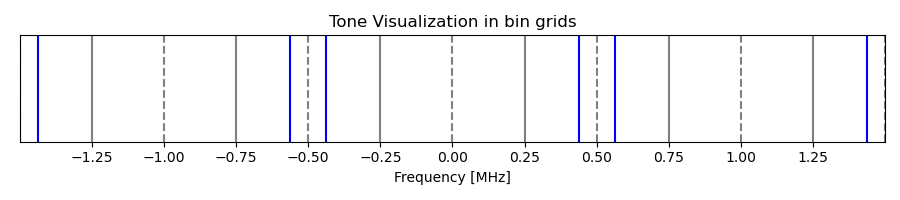

In [27]:
sub_band_centers = np.arange(-256, 256, 0.5)  # MHz

plt.figure(500, figsize=(9, 2), clear=True)
plt.title("Tone Visualization in bin grids")

ax = plt.gca()

# Plot the grid lines in one go (fast)
ax.vlines(sub_band_centers - 0.25, 0, 1, colors='grey', linestyles='-',
          transform=ax.get_xaxis_transform())
ax.vlines(sub_band_centers,        0, 1, colors='grey', linestyles='--',
          transform=ax.get_xaxis_transform())

# Plot all tone lines in one go too (fast)
ax.vlines(np.asarray(safe_freqs) / 1e6, 0, 1, colors='blue', linestyles='-',
          transform=ax.get_xaxis_transform())

plt.xlim(-1.5, 1.5)
plt.xticks(np.linspace(-1.25, 1.25, 11))
plt.xlabel("Frequency [MHz]")
plt.yticks([])
plt.tight_layout()
plt.show()

In [28]:
chan_under_test = 2
clearChanTones(chan_under_test)

amps = 1.0  # this value must not be greater than 1
best_phis, freqs_actual, peak, crest = genBestPhis(safe_freqs)

# for chan in range(1,5):
#     writeComb(chan, safe_freqs, amps, best_phis)

start_time = time.time()
freqs_actual, bin_map, transmit_bin_count, secondTone_flag = writeComb(chan_under_test, safe_freqs, amps, best_phis)
stop_time = time.time()
print(stop_time-start_time)

print("secondTone_flag = ", secondTone_flag)
# shiftInBin(1, 0)
# shiftInBin(1, 198.3642578125)
# np.savetxt(f"twoOctaveReadout_files/bin_map_test.csv", bin_map, delimiter=",")

2.4135351181030273
secondTone_flag =  True


In [ ]:
# print(safe_freqs[514])
# print(best_phis[514])
# safe_freqs[514] = 1000000

# _,_,_,_ = writeComb(2, safe_freqs, amps, best_phis)

In [ ]:
# dtw = set_fine_nco_frequency(4, 0.001)  # MHz
# correction = 2*np.pi*(dtw/2**22)*372.823443759
# print(correction)

In [ ]:
# chan_under_test = 2

# f, Z = _sweep(chan_under_test, 0, safe_freqs, 500, chan_bandwidth=None, N_accums=8, wait1=0.003, wait2=0.02)

In [ ]:
# mag = np.abs(Z)
# phase = np.angle(Z)
# # phase = np.unwrap(phase)

# plt.figure(8, figsize=(9, 5))
# plt.title("VNA Sweep")
# plt.plot(f, db(mag), '.')
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Power [dB]")
# plt.axvline(x=159.25e6, color='red', linestyle='--', label='159.25 MHz')
# plt.axvline(x=159.75e6, color='red', linestyle='--', label='159.75 MHz')
# plt.ylim(70, 110)
# # plt.xlim(158e6, 161e6)
# plt.legend()
# plt.show()

# plt.figure(9, figsize=(9, 5))
# plt.title("VNA Sweep")
# plt.plot(f, phase, '.')
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Phase [rad]")
# plt.axvline(x=159.25e6, color='red', linestyle='--', label='159.25 MHz')
# plt.axvline(x=159.75e6, color='red', linestyle='--', label='159.75 MHz')
# plt.axhline(y=0.3121, color='grey', linestyle='--', label='0.3121 rad')
# plt.xlim(158e6, 161e6)
# # plt.ylim(-200, 200)
# plt.legend()
# plt.show()

In [ ]:
# amps = np.ones(1000) * 1
# amps[501] = 0.7
# freqs = np.load('twoOctaveReadout_files/test_comb/f_rf_tones_comb_cust.npy') - 1.024e9
# # freqs[501] -= 5*488.28125
# phases = np.load('twoOctaveReadout_files/test_comb/p_tones_comb_cust.npy')
# phases[501] -= -1.0319265659550785
# print(freqs.shape)

# freqs_actual, bin_map, transmit_bin_count, secondTone_flag = writeComb(2, freqs, amps, phases)
# print("secondTone_flag = ", secondTone_flag)

In [ ]:
# print(bin_map[0:10])
# bin_map_reshape = bin_map.reshape((512, 4))
# print(bin_map_reshape[0:2])

# print("np.unique(bin_map).shape = ", np.unique(bin_map).shape)
# print("transmit_bin_count = ", transmit_bin_count)

# beat_dphi_map = np.loadtxt(f"twoOctaveReadout_files/beat_dphi_map_1.csv", delimiter=",")
# print(beat_dphi_map[0:10])
# dphi = np.loadtxt(f"twoOctaveReadout_files/dphi_1.csv", delimiter=",")
# print(-2*dphi[0:10])
# print("np.unique(beat_dphi_map).shape = ", np.unique(beat_dphi_map).shape)

In [ ]:
# # This cell resets the receive output bin order to (0 to 2047)
# initBinMap(1)

# chan = 1
# beat_dphi_2048 = np.zeros(2048, dtype=float)
# beat_dphi_map = np.loadtxt(f"twoOctaveReadout_files/beat_dphi_map_{chan}.csv", delimiter=",")
# beat_dphi_2048[bin_map] = beat_dphi_map
# loadBeatDphiMap(1, beat_dphi_2048)

In [ ]:
# demo_f_shift = 198.3642578125
# demo_dphi_shift=(demo_f_shift/1000000) * 2*np.pi

# chan = 1
# bin_num = np.loadtxt(f"twoOctaveReadout_files/bin_num_{chan}.csv", delimiter=",").astype(np.int64)
# dphi = np.loadtxt(f"twoOctaveReadout_files/dphi_{chan}.csv", delimiter=",")
# init_re = np.loadtxt(f"twoOctaveReadout_files/init_re_{chan}.csv", delimiter=",")
# init_im = np.loadtxt(f"twoOctaveReadout_files/init_im_{chan}.csv", delimiter=",")
# beat_dphi_map = np.loadtxt(f"twoOctaveReadout_files/beat_dphi_map_{chan}.csv", delimiter=",")

# bin_under_test = 24
# test_index = int(np.where(bin_num == bin_under_test)[0])
# print("Bin: ", bin_num[test_index])
# print("dphi = ", dphi[test_index])
# print("demo_f_shift = ", demo_f_shift)
# # writeTone(1, bin_num[test_index]%8, bin_num[test_index]//8, dphi[test_index]+demo_dphi_shift, init_re[test_index], init_im[test_index])
# # writeTone(1, bin_num[test_index]%8, bin_num[test_index]//8, dphi[test_index], init_re[test_index], init_im[test_index])

# test_index = int(np.where(bin_map == bin_under_test)[0])
# print("Bin: ", bin_map[test_index])
# print("beat_dphi = ", beat_dphi_map[test_index])
# # writeBeatDphi(1, test_index%4, test_index//4, beat_dphi_map[test_index] - 2*demo_dphi_shift)
# # writeBeatDphi(1, test_index%4, test_index//4, beat_dphi_map[test_index])

In [ ]:
chan_under_test = 2

ov_status = setPSBscaleConst(chan_under_test, C=37170*2)  # 37170*2 * 1.13 | 1.3
print(ov_status)

In [29]:
chan_under_test = 2
I, Q = getSnapData(chan_under_test, 3)
result = (I + 1.j * Q)
result = result.reshape((-1, 1024))
print("result.shape = ", result.shape)
print("magnitude range of result: ")
print_min_max(result)

result_power = np.abs(result)**2
# print("result_power.T.flatten():\n", result_power.T.flatten()[0:20])

sampling_rate = 1.024e9/(2048*1024)  # Hz
mean_power = np.mean(result_power, axis=0)
variance = np.var(result.real, axis=0) + np.var(result.imag, axis=0)
SNR = mean_power / variance
print("SNR.shape = ", SNR.shape)
SNR_dBcPerHz = 10*np.log10(SNR) + 10*np.log10(sampling_rate)
print("SNR in each bin: \n", SNR_dBcPerHz[434:470])
print(f"Avg SNR = {np.mean(SNR_dBcPerHz)} [dBc/Hz]")

print("time stream angle: ", np.angle(np.mean(result[:, 2])))

result.shape =  (8, 1024)
magnitude range of result: 
46123.74522954527 <-> 112469.64615397347
SNR.shape =  (1024,)
SNR in each bin: 
 [84.07632319 81.91994944 87.4723047  85.6188807  84.30999591 80.48935063
 84.30237312 81.5581682  81.6126377  82.52431472 92.4805039  82.13198454
 80.77352295 85.78821844 82.07197614 84.07248077 82.0699691  82.76061785
 86.97248681 84.11392734 84.72806389 83.6381193  84.03297631 83.78359173
 85.68838026 82.79167068 83.10771082 81.56782474 81.1738658  82.7694738
 84.6232727  85.8312477  82.10156332 84.92858151 79.87328088 84.61594388]
Avg SNR = 87.05405280769065 [dBc/Hz]
time stream angle:  2.6363703929068936


In [ ]:
# Visualize time stream on the IQ plane
plt.figure(figsize=(5,5))
for i in range(1024):
    plt.plot(result[:, i].real, result[:, i].imag, ".")
plt.axvline(x=0)
plt.axhline(y=0)
plt.xlim(-150000, 150000)
plt.ylim(-150000, 150000)

In [ ]:
# y = 10*np.log10(mean_power[0:1024])
# mask = np.isin(np.arange(len(y)), second_tone_index)

# plt.figure(380, figsize=(9, 5), clear=True)
# plt.title("mean power in bins (dB)")
# plt.plot(y, '.', alpha=1)
# plt.plot(np.where(mask)[0], y[mask], '.', markersize=5)

# # plt.xlim(140, 220)
# # arr = np.arange(143, 143 + 6*13, 6)
# # for i in arr:
# #     plt.axvline(x=i, linestyle='--', color='grey')

# # plt.xlim(0, 60)
# # arr = np.arange(1, 1 + 6*15, 6)
# # for i in arr:
# #     plt.axvline(x=i, linestyle='--', color='grey')

# plt.ylim(70, 110)
# # plt.legend()
# plt.show()

<IPython.core.display.Javascript object>


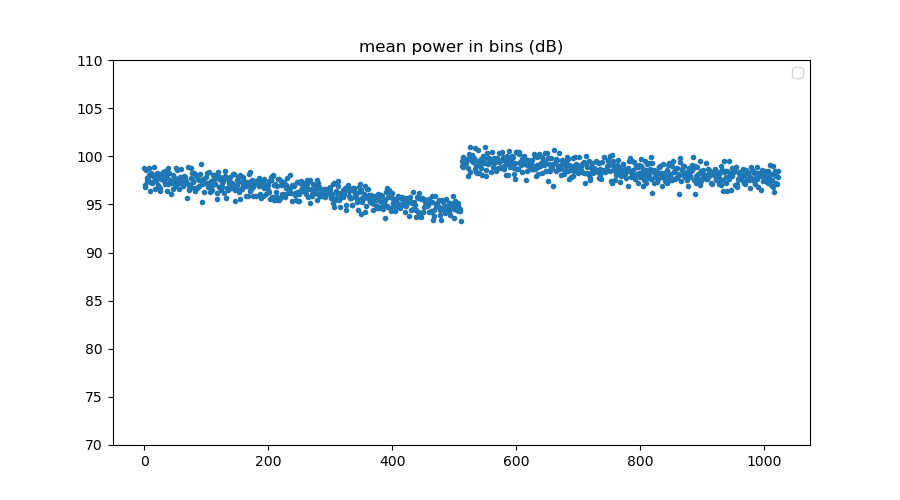

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [30]:
meanPower_fig = plt.figure(1, figsize=(9, 5))
plt.title("mean power in bins (dB)")
plt.plot(10*np.log10(mean_power[0:1024]), '.', alpha=1)
# for x in bin_map:
#     plt.axvline(x=x, color='grey', linestyle='-', alpha=0.5)
# plt.axvline(x=530, color='red', linestyle='--', label='bin=530')
# plt.axvline(x=500, color='grey', linestyle='--', label='bin=500')
# plt.xlim(0, 250)
plt.ylim(70, 110)
plt.legend()
plt.show()

In [ ]:
# plt.figure(2, figsize=(9, 5))
# plt.plot(10*np.log10(result_power.T.flatten()[512*8:600*8]), '.')
# plt.show()

In [ ]:
# fs=1.024e9
# acc_factor = 1024
# channel_to_plot = 3  # test_index
# fft_length = 32

# plt.figure(3, figsize=(9, 5))
# plt.title(f"RFSoC Output Spectrum (fine, channel = {channel_to_plot})")
# plt.axvline(x=0, color='grey', linestyle='--')
# xf = np.fft.fftfreq(fft_length, 1./(fs/(2048*acc_factor)))
# plt.plot(xf, db(np.fft.fft(result[:, channel_to_plot], fft_length)), '.')
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Power [dB, normalized]")
# plt.axhline(y=-6, color='green', linestyle='--', label='-6 dB')
# plt.axhline(y=44, color='green', linestyle='--', label='44 dB')
# plt.axhline(y=84, color='green', linestyle='--', label='84 dB')
# plt.axvline(x=-119.366207319*2, color='grey', linestyle='--', label='f = 976.5625')
# # plt.axvline(x=10, color='grey', linestyle='--', label='f = 10')
# # plt.axvline(x=122.0703125, color='orange', linestyle='--', label='f = 122.0703125')
# # plt.axvline(x=106.81152, color='grey', linestyle='--', label='f = 122.07')
# # plt.axvline(x=167.8466796875, color='red', linestyle='--', label='f = 167.8466796875')
# plt.axvline(x=198.3642578125, color='red', linestyle='--', label='f = 198.3642578125')
# # plt.axvline(x=976.5625, color='grey', linestyle='--', label='f = 976.5625')

# # plt.xlim(5, 15)
# # plt.ylim(-70, 10)
# # plt.ylim(95, 105)
# plt.legend()
# plt.show()

In [31]:
chan_under_test = 2
I, Q = getSnapData(chan_under_test, 1)
PSB_out = (I + 1.j * Q)
I, Q = getSnapData(chan_under_test, 0)
ADC_out = (I + 1.j * Q)
print("PSB output range:")
print_min_max(PSB_out)
print("ADC output range:")
print_min_max(ADC_out)
print("ADC_out.shape = ", ADC_out.shape)

print('\n')
print_min_max(ADC_out.real)
print_min_max(ADC_out.imag)

PSB output range:
32.2490309931942 <-> 12167.404201389876
ADC output range:
5.0 <-> 837.6980362875396
ADC_out.shape =  (8192,)


0.0 <-> 791.0
0.0 <-> 787.0


In [ ]:
plt.figure(4, figsize=(9, 5))
plt.plot(PSB_out.real[600:700])
plt.plot(PSB_out.imag[600:700])
plt.show()

<IPython.core.display.Javascript object>


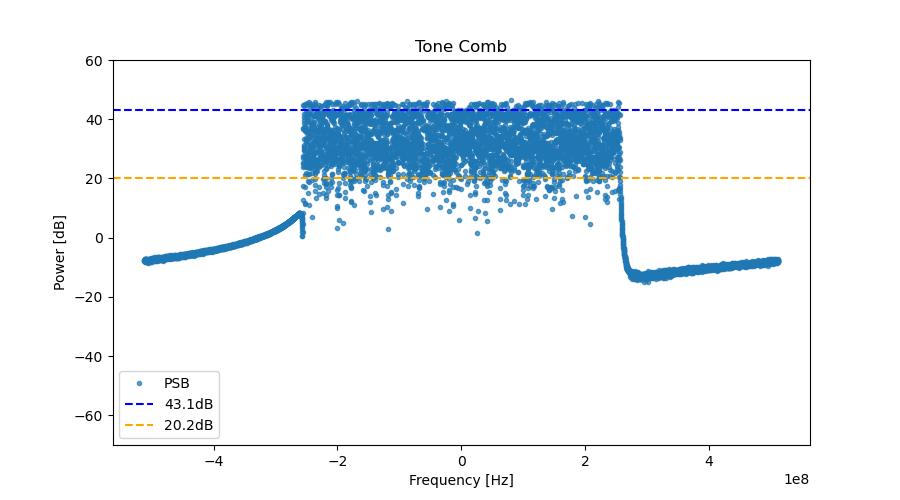

In [34]:
fs=1.024e9
fft_length = 8192 * 1
ADC_out_scale = 2**0

figComb = plt.figure(5, figsize=(9, 5))
plt.title(f"Tone Comb")
xf = np.fft.fftfreq(fft_length, 1./fs)
plt.plot(xf, db(np.fft.fft(PSB_out, fft_length)/fft_length), '.', label='PSB', alpha=0.7)
# plt.plot(xf, db(np.fft.fft(ADC_out*ADC_out_scale, fft_length)/fft_length), '.', label='ADC', alpha=0.7) # , '.'
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")

plt.axhline(y=43.1, color='blue', linestyle='--', label='43.1dB')
plt.axhline(y=20.2, color='orange', linestyle='--', label='20.2dB')
# plt.axhline(y=-28, color='black', linestyle='--', label='-28dB')
# plt.axhline(y=-34, color='red', linestyle='--', label='-34dB')

# plt.axhline(y=22-6, color='orange', linestyle='--', label='22 dB')
# plt.axhline(y=43.7-6, color='blue', linestyle='--', label='43.7 dB')
# plt.axhline(y=-12, color='orange', linestyle='--', label='-12 dB')
# plt.axhline(y=-19.9, color='blue', linestyle='--', label='-19.9 dB')

# plt.axvline(x=-240e6, color='red', linestyle='--')
# plt.axvline(x=-250e6, color='red', linestyle='--')

# plt.axvline(x=(test_bin-1)*500e3-250e3)
# plt.axvline(x=(test_bin-1)*500e3, linestyle='--')
# plt.axvline(x=test_bin*500e3-250e3, color='green')
# plt.axvline(x=test_bin*500e3, linestyle='--', color='green')
# plt.axvline(x=test_bin*500e3+250e3, color='green')
# plt.axvline(x=(test_bin+1)*500e3, linestyle='--')
# plt.axvline(x=(test_bin+1)*500e3+250e3)
# plt.xlim(test_bin*500e3-250e3-500e3*5, test_bin*500e3+250e3+500e3*5)

# plt.ylim(-70, 10)
plt.ylim(-70, 60)
plt.legend()
plt.show()